In [1]:
pip install pandas

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.metrics import Recall,Precision,AUC
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model,Sequential
from tensorflow import keras
from keras.layers import Input,DepthwiseConv2D,ReLU, Add
from keras import layers, models
from keras.applications import VGG19
from keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

def vgg19():
    # Load MobileNetV2 pre-trained on ImageNet
    input_shape=(224,224, 3)
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers:
      layer.trainable=False
    model=Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512,"relu",kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              metrics=['accuracy',Precision(),Recall(),AUC()],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

In [8]:
import zipfile
import os
import datetime

image_dir=Path('E:/Final_Project/Deepfake/celeb-df')
filepaths= list(image_dir.glob(r'**/*.jpg'))
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df=pd.concat([filepaths,labels],axis=1)

train_df,test_df=train_test_split(image_df,train_size=0.7,shuffle=True,random_state=1)
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False,
    seed= 42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False
)

plt.figure(figsize=(20, 20))
for images, labels in train_images:
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(int(labels[i]))
        plt.axis("on")
    break

# Create the model
model =vgg19()
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()
history=model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
         tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=5
        )
    
    ]
)
model.save_weights('my_model.weights_vgg19.h5')
model.save('vgg19_model.h5') 

results=model.evaluate(test_images,verbose=0)
print("test loss: {:.5f}".format(results[0]))
print("test acc: {:.2f}".format(results[1]*100))
predictions=(model.predict(test_images)>=0.5).astype(int)
cm=confusion_matrix(test_images.labels,predictions,labels=[0,1])
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
plt.xticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.yticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()



Found 92 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               12845568  
        

In [ ]:
report = classification_report(test_images.labels,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        46
           1       0.00      0.00      0.00         4

    accuracy                           0.92        50
   macro avg       0.46      0.50      0.48        50
weighted avg       0.85      0.92      0.88        50



c:\Users\AKSHU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AKSHU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\AKSHU\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from PIL import Image
import numpy as np
# Specify the path to your image file
image_path = "E:/Final_Project/Deepfake/celeb-df/Real/hard_13_1111.jpg"
# Open the image
image = Image.open(image_path)

# Resize the image to the desired dimensions
image = image.resize((224, 224))

# Convert the image to a NumPy array
image_array = np.array(image)

# Reshape the image array to include the batch dimension
image_array = image_array.reshape((1, 224, 224, 3))
resized_image_path = "E:/Final_Project/Deepfake/resized_2"
image.save(resized_image_path + ".jpg")

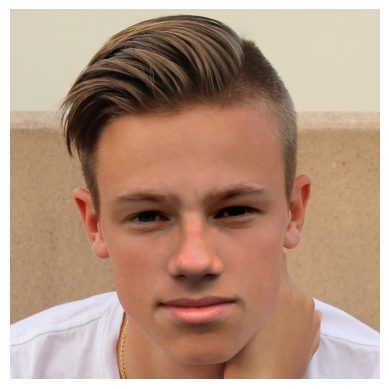

1/1 [==============================] - 1s 617ms/step
Real


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def prediction(Image):
    # Load the image
    img = mpimg.imread(Image)

    # Plot the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    image = tf.keras.preprocessing.image.load_img(Image, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = tf.expand_dims(input_arr, axis=0)
    input_arr /= 255.
    pred = model.predict(input_arr)
    if(pred>=0.5):
        predict="Real"
    else:
        predict="Fake"

    return predict
Img1 = "E:/Final_Project/Deepfake/celeb-df/Real/hard_13_1111.jpg"
print(prediction(Img1))


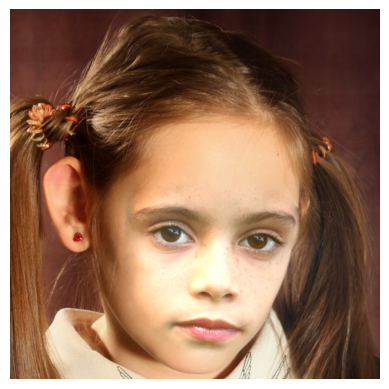

1/1 [==============================] - 1s 764ms/step
Fake


In [ ]:
img2="E:\Final_Project\Deepfake\celeb-df\Fake\easy_72_1111.jpg"
print(prediction(img2))

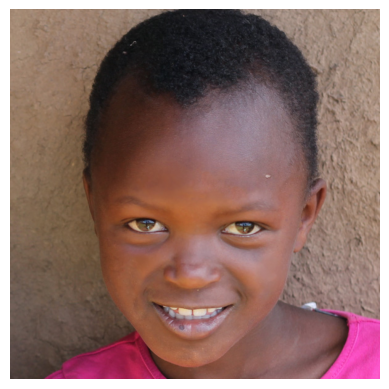

1/1 [==============================] - 1s 673ms/step
Fake


In [ ]:
img3="E:/Final_Project/Deepfake/celeb-df/Real/hard_34_1111.jpg"
print(prediction(img3))

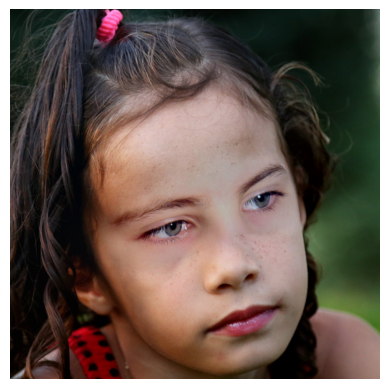

1/1 [==============================] - 2s 2s/step
Fake


In [ ]:
img4="E:\Final_Project\Deepfake\celeb-df\Fake\easy_75_1100.jpg"
print(prediction(img4))